In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath

# Get the Crystal Geometries

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 10.
pre_length = 1e6

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=708.2581446128465,
                              sigma_y=708.2581446128465,
                              sigma_z=1.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Split
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(1.5 * 1e-3 / 5.)  # This is the deviation angle.
half_period = util.get_grating_period(dtheta=dtheta,
                                      klen_in=my_pulse.klen0) / 2

grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(half_period)
grating_list[0].set_b(half_period)
grating_list[1].set_a(half_period)
grating_list[1].set_b(half_period)

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay Lines
# ----------------------------------------------------------------------------------------------------------
# Some meta data for the delay line.
h_length = 2. * np.pi / (1.9201 * 1e-4)

# Some crystal properties
chi0 = complex(-0.97631E-05, 0.14871E-06)
chih_sigma = complex(0.59310E-05, -0.14320E-06)
chihbar_sigma = complex(0.59310E-05, -0.14320E-06)
chih_pi = complex(0.46945E-05, -0.11201E-06)
chihbar_pi = complex(0.46945E-05, -0.11201E-06)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta

# Bragg angle
bragg = np.radians(18.836) + 13e-6
miscut = np.deg2rad(10.)

# Get crystal angles
eta_b1 = np.zeros(6, dtype=np.float64)
theta_b1 = np.array([np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg,
                     3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg])
rho_b1 = theta_b1 + np.pi
tau_b1 = np.array([0., miscut, miscut, 0.,
                   -miscut, -miscut])

# Add the effect of the global rotation due to the grating momentum transfer
theta_b1 += angle_offset_1
rho_b1 += angle_offset_1

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=6,
                                           hlen=np.array([h_length, ] * 6),
                                           theta=theta_b1,
                                           eta=eta_b1,
                                           rho=rho_b1,
                                           tau=tau_b1,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - dtheta
bragg = np.radians(18.836) + 13e-6

# Get crystal angles
eta_b2 = np.zeros(4, dtype=np.float64)
theta_b2 = np.array([3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg])
rho_b2 = theta_b2 + np.pi
tau_b2 = np.zeros(4, dtype=np.float64)

# Add the effect of the global rotation due to the grating momentum transfer
theta_b2 += angle_offset_2
rho_b2 += angle_offset_2

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=4,
                                           hlen=np.array([h_length, ] * 4),
                                           theta=theta_b2,
                                           eta=eta_b2,
                                           rho=rho_b2,
                                           tau=tau_b2,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ------------------------------------------------------
#   Define the positions
# ------------------------------------------------------
path_list_fix = [5e6 - 10e4, 1e5, 5e5, 1.05e5, 6e6, 1e6]
path_list_var = [5e6, 1e5, 2e5, 2e4, 5e4, 8.5e4, 6e6, 1e6]
delay_time = 150

# Arrange the crystals

In [3]:
(fix_branch_path,
 kout_fixed,
 intersect_fixed,
 var_branch_path,
 kout_var,
 intersect_var) = lightpath.adjust_path_length(delay_time=delay_time,
                                               fix_branch_path=path_list_fix,
                                               fix_branch_crystal=crystal_list_2,
                                               var_branch_path=path_list_var,
                                               var_branch_crystal=crystal_list_1,
                                               grating_pair=grating_list,
                                               kin=my_pulse.k0)

C:\Users\haoyuan\Documents\GitHub\CrystalDiff\CrystalDiff\lightpath.py:195: RuntimeWarning: invalid value encountered in double_scalars
  intersect_final = intersect_list[-1] + path_list[-1] * kout_g2[0] / util.l2_norm(kout_g2[0])


In [14]:
holder = np.zeros(3)

for x in crystal_list_1:
    print(x.normal)
    holder += x.normal

[ 0.         -0.94634549  0.32315665]
[ 0.17364818  0.93196837 -0.31824718]
[0.17364818 0.93215915 0.31768794]
[ 0.         -0.94653921 -0.32258879]


In [15]:
holder

array([ 3.47296355e-01, -2.87571718e-02,  8.62715155e-06])

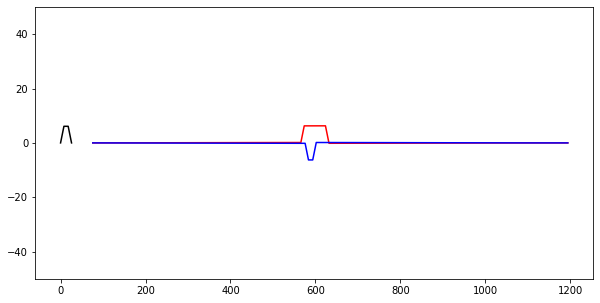

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axes.plot(intersect_branch_1[:,2]/1e4, intersect_branch_1[:,1]/1e4,'r')
axes.plot(intersect_branch_2[:,2]/1e4, intersect_branch_2[:,1]/1e4,'b')
axes.plot(intersect_branch_0[:,2]/1e4, intersect_branch_0[:,1]/1e4,'k')

#axes.set_xlim([5e2-70, 5e2 + 150])
axes.set_ylim([-50, 50])
#axes.set_aspect('equal', 'datalim')

plt.show()

In [17]:
# Set the range of the index to save
z_idx_range = 600
num1 = 550
num2 = 50
d_num = 512

# -------------------------------------------------------------
#            Get Field for Branch 2
# -------------------------------------------------------------
tic = time.time()

(result_3d_dict_2,
 result_2d_dict_2,
 check_dict_2
) = groutine.get_split_delay_single_branch_field_shear_fix(grating_pair = grating_list,
                                                           shear_fix_crystals = shear_fix_crystal,
                                                           channel_cuts = crystal_list_2,
                                                           total_path = total_path, 
                                                           observation = observation,
                                                           my_pulse = my_pulse,
                                                           kx_grid = kx_grid,
                                                           ky_grid = ky_grid,
                                                           kz_grid = kz_grid,
                                                           pulse_delay_time = 0.,
                                                           pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                                           grating_orders = [-1., 1.],
                                                           number_x = number_x,
                                                           number_y = number_y,
                                                           number_z = number_z,
                                                           z_idx_range = z_idx_range,
                                                           num1 = num1,
                                                           num2 = num2, 
                                                           d_num = 512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.07 seconds to prepare the variables.
It takes 17.31 seconds to get the field for branch 1.


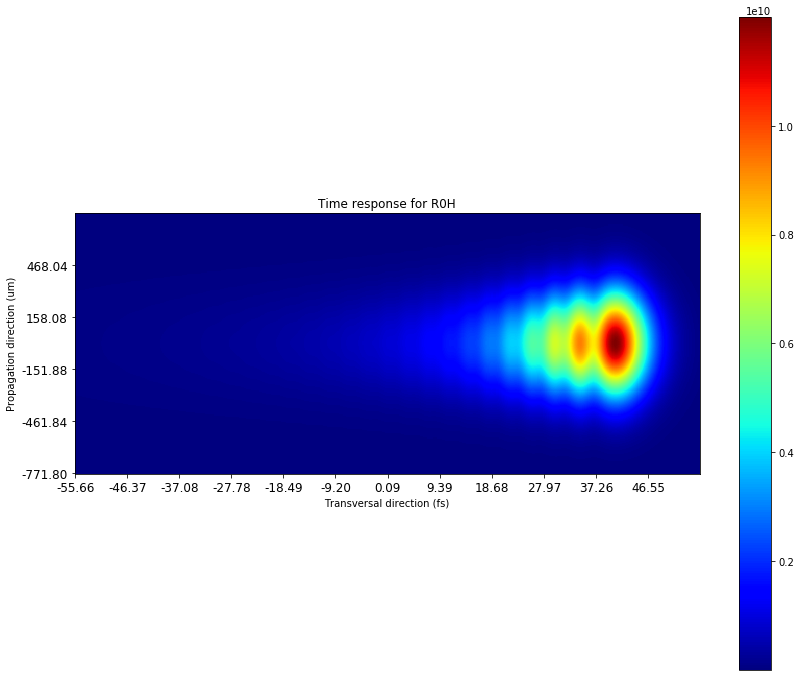

In [18]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_2 = np.fft.ifftshift(np.fft.ifft(result_2d_dict_2['y_field_2d'], axis=0), axes=0)

im = axes.imshow(np.abs( field_2 ),
                 #vmin=  17,
                 #vmax = 25.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_ylabel("Propagation direction (um)")
axes.set_xlabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()

In [19]:
# -------------------------------------------------------------
#            Get Field for Branch 2
# -------------------------------------------------------------
tic = time.time()

(result_3d_dict_1,
 result_2d_dict_1,
 check_dict_1
) = groutine.get_split_delay_single_branch_field_shear_fix(grating_pair = grating_list,
                                                           shear_fix_crystals = shear_fix_crystal,
                                                           channel_cuts = crystal_list_1,
                                                           total_path = total_path, 
                                                           observation = observation,
                                                           my_pulse = my_pulse,
                                                           kx_grid = kx_grid,
                                                           ky_grid = ky_grid,
                                                           kz_grid = kz_grid,
                                                           pulse_delay_time = 0.,
                                                           pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                                           grating_orders = [1., -1.],
                                                           number_x = number_x,
                                                           number_y = number_y,
                                                           number_z = number_z,
                                                           z_idx_range = z_idx_range,
                                                           num1 = num1,
                                                           num2 = num2, 
                                                           d_num = 512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.04 seconds to prepare the variables.
It takes 17.30 seconds to get the field for branch 1.


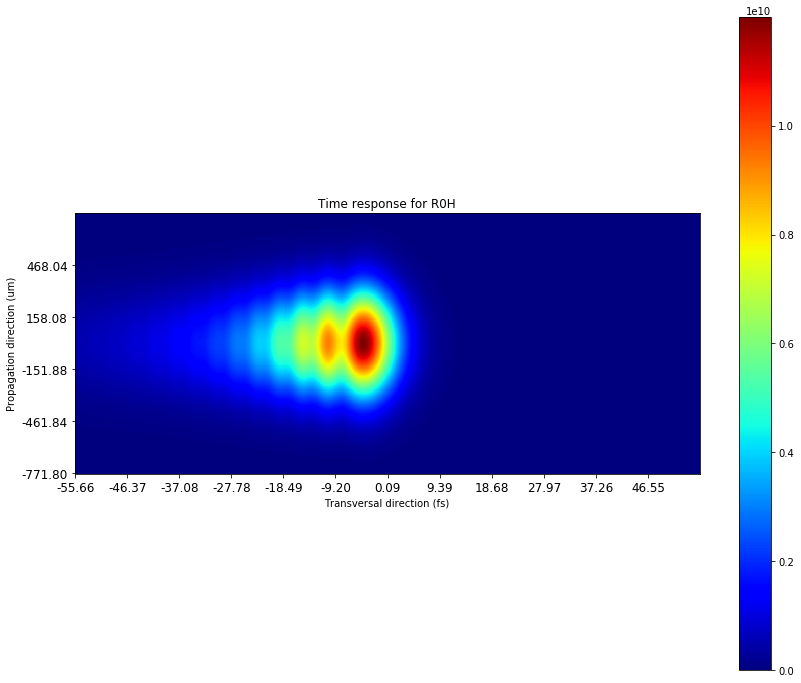

In [20]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_1 = np.fft.ifftshift(np.fft.ifft(result_2d_dict_1['y_field_2d'], axis=0), axes=0)

im = axes.imshow(np.abs( field_1 ),
                 #vmin=  17,
                 #vmax = 25.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_ylabel("Propagation direction (um)")
axes.set_xlabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()

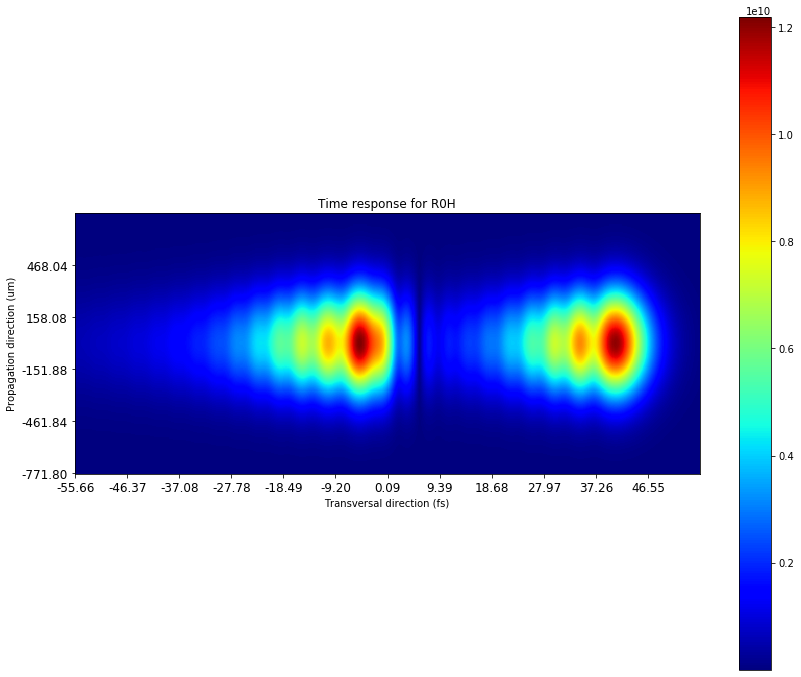

In [21]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_1 = np.fft.ifftshift(np.fft.ifft(result_2d_dict_1['y_field_2d'], axis=0), axes=0)

im = axes.imshow(np.abs( field_1 + field_2 ),
                 #vmin=  17,
                 #vmax = 25.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_ylabel("Propagation direction (um)")
axes.set_xlabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()